Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt

jupyter_black.load()

In [2]:
import Oasis

## Context
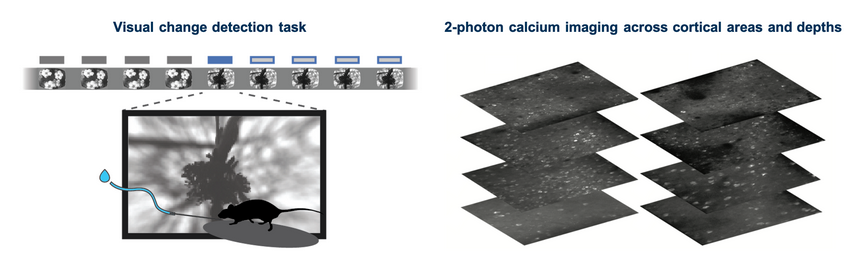

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

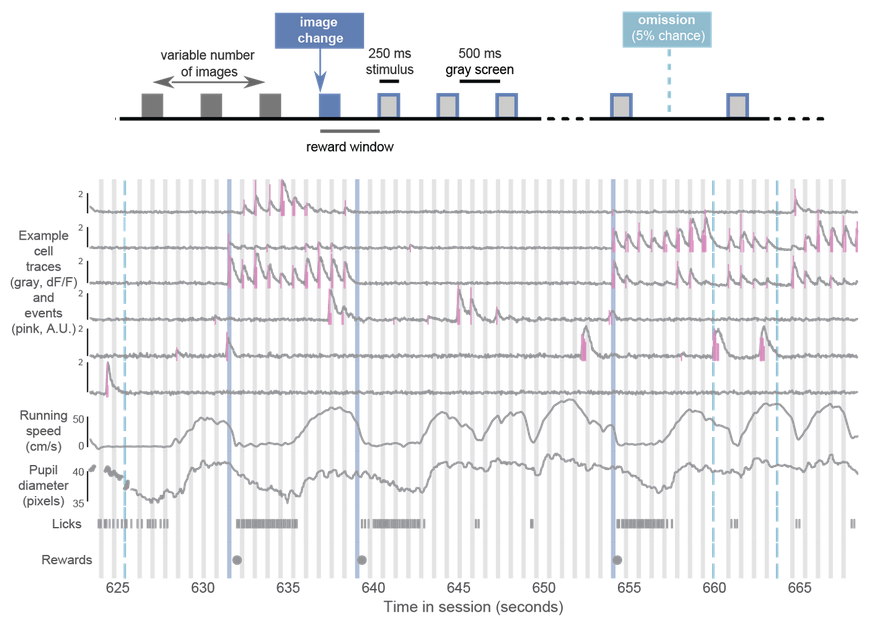

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [3]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(path="../data/")
print(type(data))
print(data.keys())
print("Overview of the data")
print_info(data)
print(data["stim_epoch_table"])
print(data["stim_table"].loc[data["stim_table"]["blank_sweep"] == 1.0])
print(data["t"])

<class 'dict'>
dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

              stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215
     temporal_frequency  orientation  blank_sweep     start       end
24                  NaN          NaN          1.0    2914.0    2974.0
26              

# Data Exploration 
* Display the df/f traces over time maby normalized to the maximum value of the trace.
    * Visualize the traces where the drifting gratings were shown.
* Display the maximum projection of the ROIs.
* Display the roi masks.

## 1. First look at all the calcium traces 
There are 106 different ROIs and to plot them nicely on top of each other we normalize them to the maximum value of the trace.

[Text(0, 100, '50'),
 Text(0, 110, '55'),
 Text(0, 120, '60'),
 Text(0, 130, '65'),
 Text(0, 140, '70'),
 Text(0, 150, '75'),
 Text(0, 160, '80'),
 Text(0, 170, '85'),
 Text(0, 180, '90'),
 Text(0, 190, '95'),
 Text(0, 200, '100'),
 Text(0, 210, '105')]

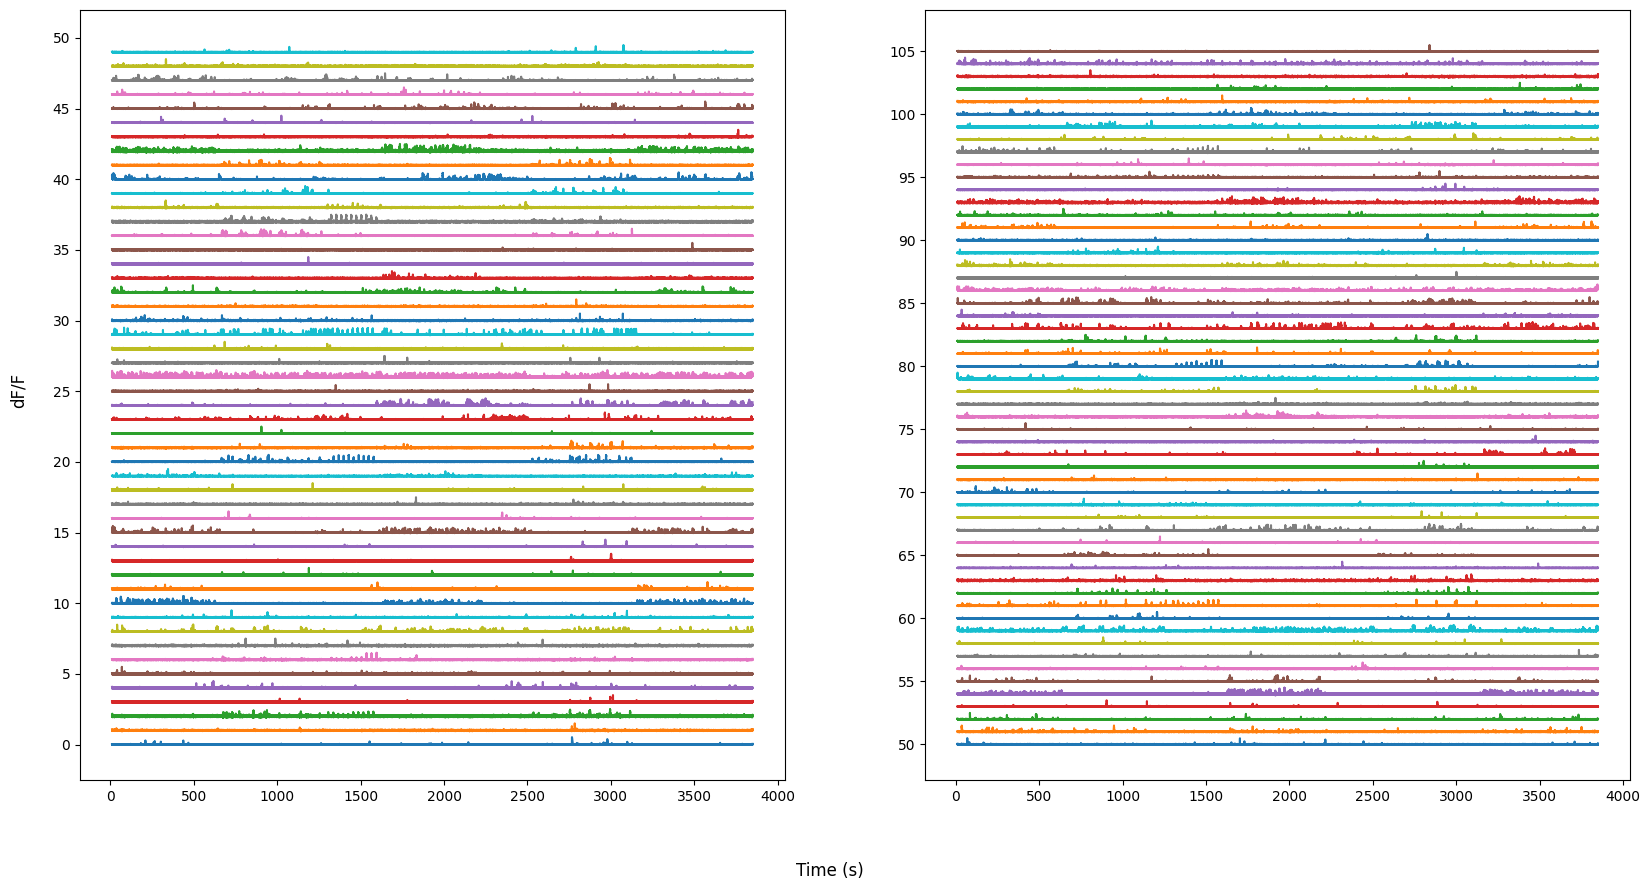

In [4]:
# plot dff traces into to subplots with the normalized dff values

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2)
for i in range(50, 106):
    axs[1].plot(data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2)
fig.supxlabel("Time (s)")
fig.supylabel("dF/F", x=0.09, y=0.5)

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))

## 2. Visualize the traces where the drifting gratings were shown
For this we used the start and stop times in the stim_epoch_table. The added vertical lines indicate the start and stop times of the drifting gratings.

In [5]:
# get the start and end times of the drifting grating stimulus

stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)
print(data["t"][np.array(start_times)])
print(data["t"][np.array(end_times)])
print(data["t"][np.array(end_times)] - data["t"][np.array(start_times)])
print(
    data["t"][data["stim_table"]["end"][0].astype(int)]
    - data["t"][data["stim_table"]["start"][0].astype(int)]
)

[  34.51795 1625.90436 3157.53702]
[ 634.02188 2225.4245  3841.13976]
[599.50393 599.52014 683.60274]
1.9952200000000033


[Text(0, 100, '50'),
 Text(0, 110, '55'),
 Text(0, 120, '60'),
 Text(0, 130, '65'),
 Text(0, 140, '70'),
 Text(0, 150, '75'),
 Text(0, 160, '80'),
 Text(0, 170, '85'),
 Text(0, 180, '90'),
 Text(0, 190, '95'),
 Text(0, 200, '100'),
 Text(0, 210, '105')]

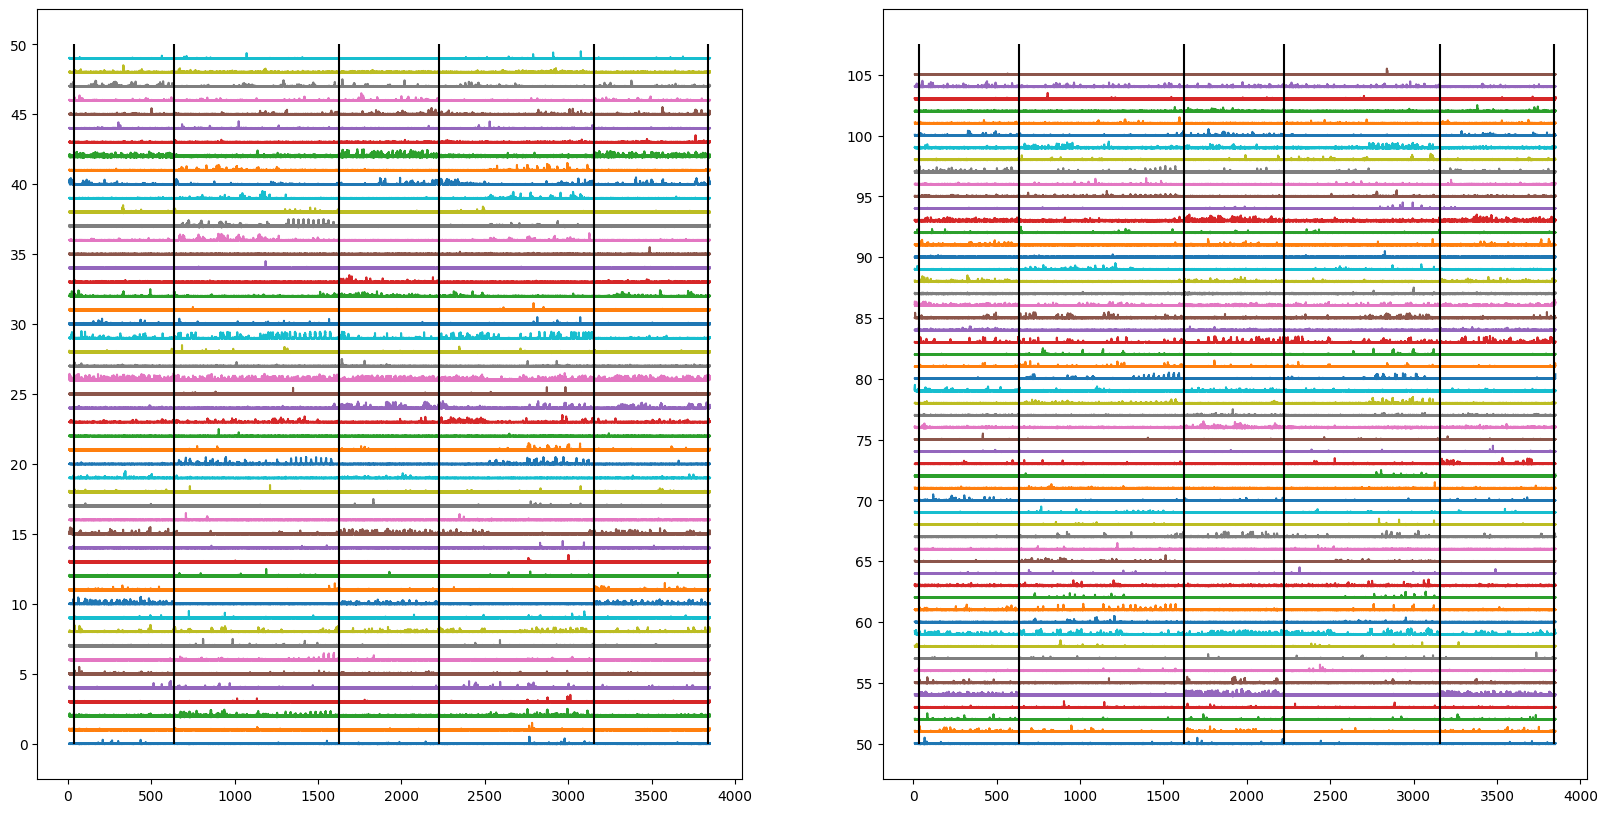

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2)
for i in range(50, 106):
    axs[1].plot(data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2)
axs[0].vlines(data["t"][np.array(start_times)], 0, 100, color="k")
axs[1].vlines(data["t"][np.array(start_times)], 100, 215, color="k")
axs[0].vlines(data["t"][np.array(end_times)], 0, 100, color="k")
axs[1].vlines(data["t"][np.array(end_times)], 100, 215, color="k")
axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))

## Some promissing cells to look at, plotting the first trial:
* 15, 42, 54; because they show high activity during the drifting gratings in all 3 trials
* we can estimate that cell 42 is selective to orientation 0° and 180°
* cell 54 is selectivwe to orientation to 135° and 315° ? 

[1.99522 1.99523 1.99523 1.96198 1.99523 1.99523 1.96197 1.99523 1.99523
 1.96198 1.96197 1.99523 1.99523 1.96197 1.99523 1.99523 1.96197 1.99523
 1.99523 1.99523 1.96198 1.99523 1.99523 1.96198 1.99523 1.99523 1.99523
 1.96198 1.99524 1.99524 1.96198 1.99524 1.99523 1.99523 1.96198 1.99524
 1.99524 1.96199 1.99523 1.99524 1.99523 1.96198 1.99524 1.99523 1.96198
 1.99524 1.99524 1.99523 1.96198 1.99523 1.99524 1.96199 1.99524 1.99524
 1.99524 1.96198 1.99524 1.99524]


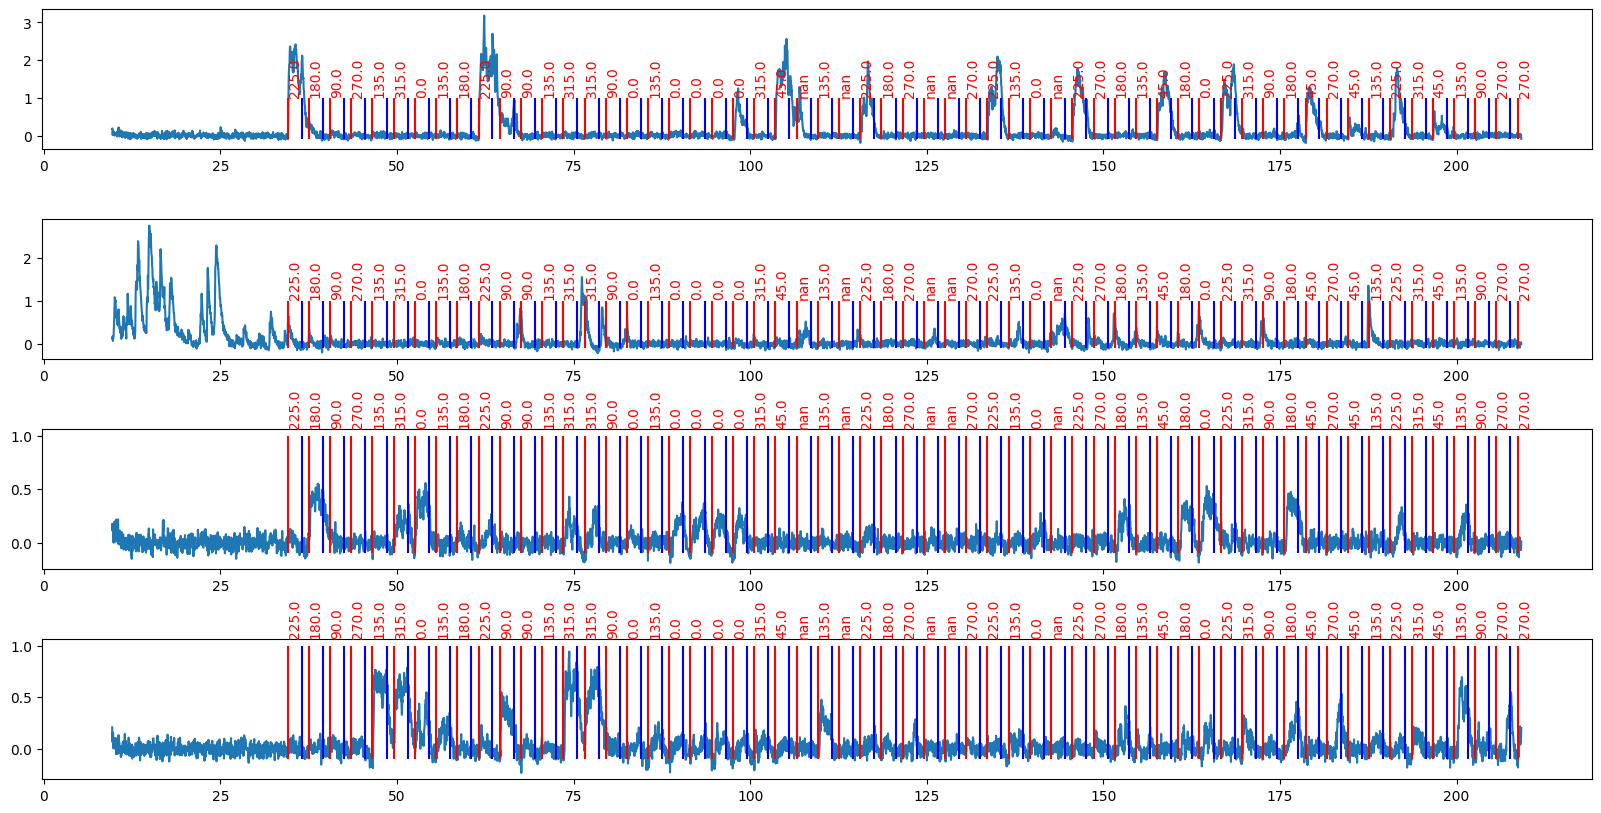

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
x_limits = 6000

for i, roi in enumerate([10, 15, 42, 54]):
    axs[i].plot(data["t"][:x_limits], data["dff"][roi, :x_limits])
    start_times_temporay = []
    for j in data["t"][
        np.array(
            data["stim_table"]["start"][data["stim_table"]["start"] < x_limits],
            dtype=int,
        )
    ]:
        axs[i].vlines(j, -0.1, 1, color="r")
        start_times_temporay.append(j)
    end_times_temporay = []
    for j in data["t"][
        np.array(
            data["stim_table"]["end"][data["stim_table"]["end"] < x_limits], dtype=int
        )
    ]:
        axs[i].vlines(j, -0.1, 1, color="b")
        end_times_temporay.append(j)

    for indx, j in enumerate(
        data["t"][
            np.array(
                data["stim_table"]["start"][data["stim_table"]["start"] < x_limits],
                dtype=int,
            )
        ]
    ):
        axs[i].text(
            j,
            1.1,
            f"{data['stim_table']['orientation'][indx]}",
            color="r",
            rotation=90,
        )


print(np.array(end_times_temporay) - np.array(start_times_temporay[:-1]))

## 3. Display the maximum projection of the ROIs, and the roi masks

[174 171 163 160 160 152 155 152 150 164 163 159 156 193 162 167 162 170
 163 185 170 173 178 177 169 183 170 168 172 164 175 162 172 172 181 164
 160 172 162 172 156 187 190 166 165 166 163 168 175 166 161 178 163 176
 168 172 177 158 178 166 159 173 180 165 160 159 160 164 163 174 160 166
 162 155 163 180 166 170 192 167 183 184 165 168 185 165 161 168 174 167
 183 163 165 170 165 165 166 170 171 173 176 166 169 161 169 168 167 168
 169 184 180 176 164 160 192 162 177 169 167 178 188 181 187 188 180 178
 180 190 212 213 225 254 292 285 214 204 228 204 213 192 189 182 194 190
 190 183 186 188 196 187 217 194 196 200 197 195 186 201 213 197 182 208
 217 207 240 219 204 217 218 210 202 206 239 249 214 218 209 228 236 243
 225 224 234 229 227 239 239 236 220 218 202 205 213 203 201 207 205 209
 209 236 229 238 231 209 208 215 240 230 212 210 215 217 218 219 258 226
 237 242 227 225 230 239 248 229 236 233 250 232 227 245 264 269 228 209
 227 225 227 244 252 271 271 257 235 238 244 236 26

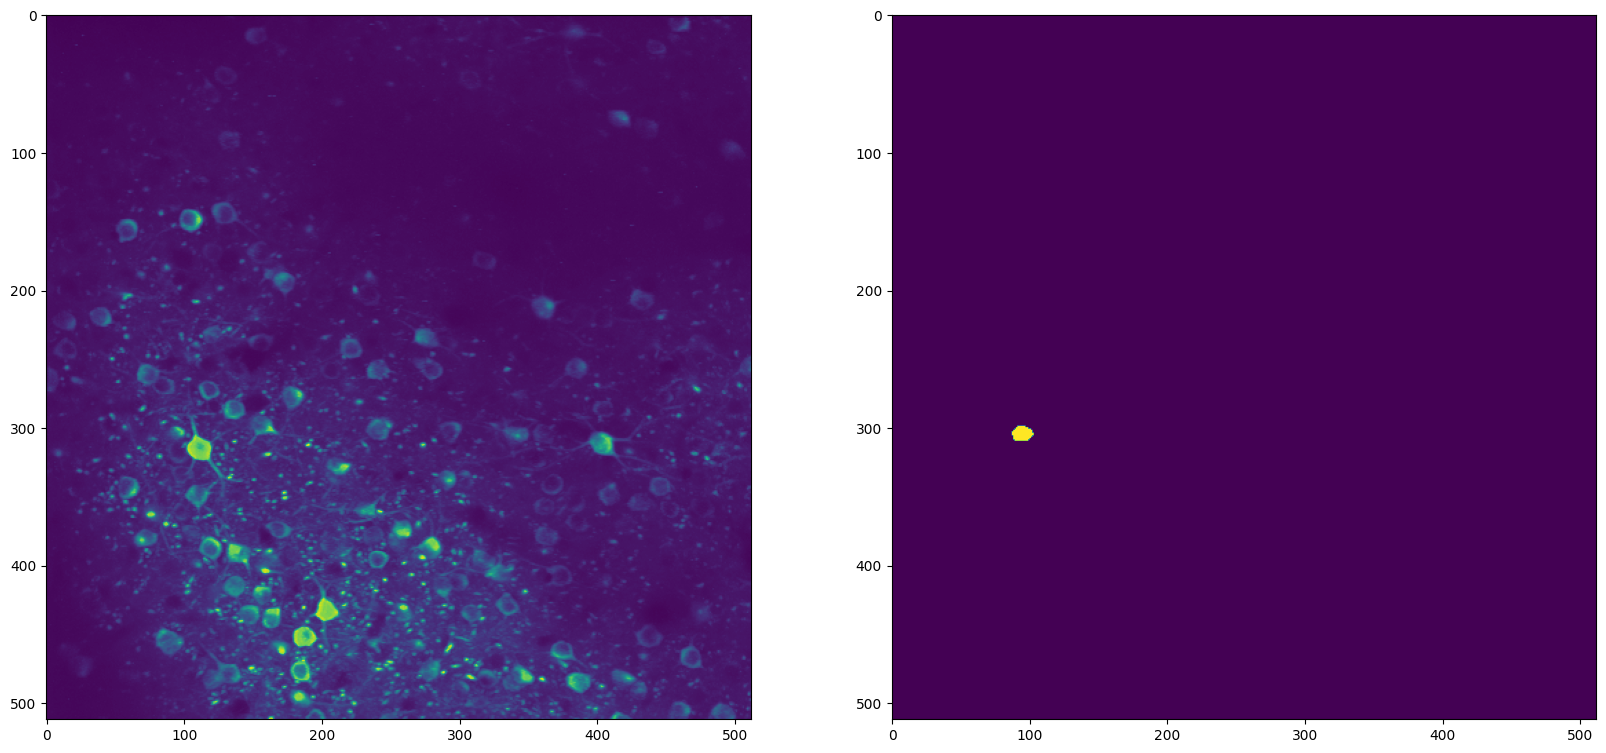

In [8]:
print(data["max_projection"][0])
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(data["max_projection"])
ax[1].imshow(data["roi_masks"][0, :, :])

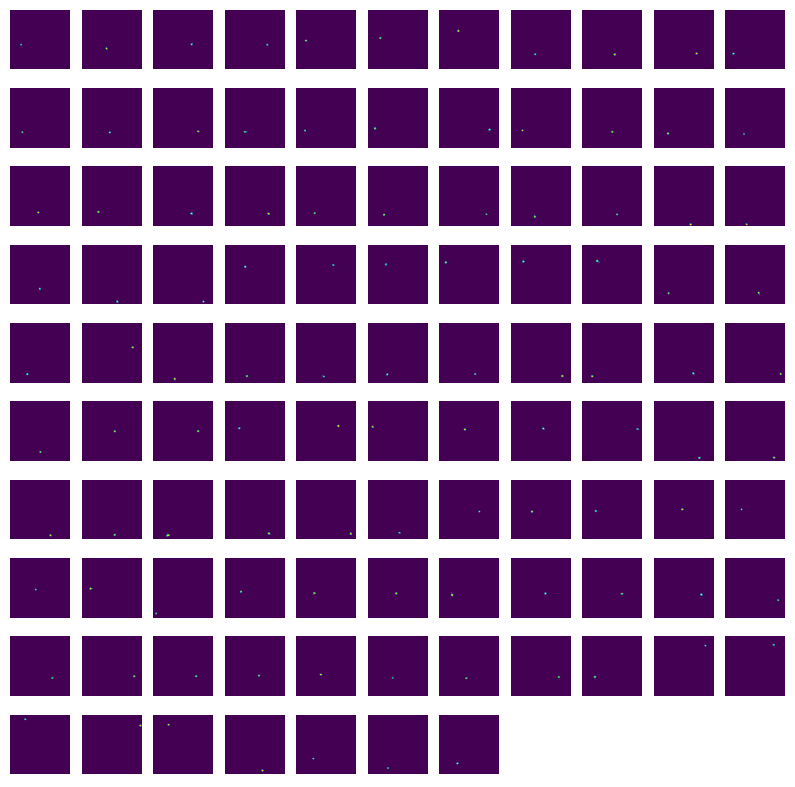

In [9]:
fig, axs = plt.subplots(10, 11, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < 106:
        ax.imshow(data["roi_masks"][i, :, :])
    ax.axis("off")
plt.show()

## 4. The trials are not equally distributed with orientation 
* but over all trials we have aroung 75 trials for each orientation and 30 trials for the blank stimulus

[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [75 75 75 74 75 75 75 74 30]
[ 1.  2.  4.  8. 15. nan] [120 120 119 120 119  30]
[0. 1.] [598  30]


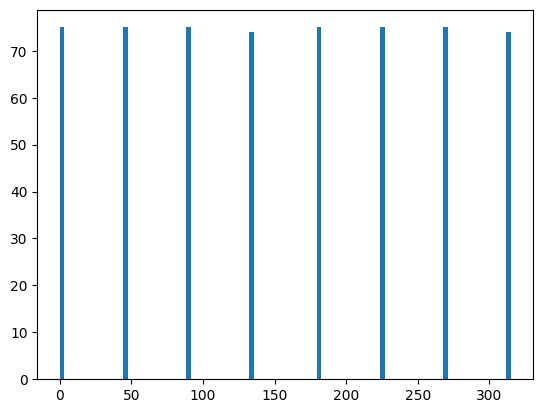

In [10]:
# dataframe where only the drifting gratings are shown
# data_drifting_stimulus = data["stim_table"][
#     data["stim_epoch_table"]["stimulus"] == "drifting_gratings"
# ]

plt.hist(data["stim_table"]["orientation"], bins=100)
uniq, coutnts = np.unique(data["stim_table"]["orientation"], return_counts=True)
print(uniq, coutnts)
freqs, counts_freqs = np.unique(
    data["stim_table"]["temporal_frequency"], return_counts=True
)
print(freqs, counts_freqs)
blanks, counts_blanks = np.unique(data["stim_table"]["blank_sweep"], return_counts=True)
print(blanks, counts_blanks)

In [11]:
uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][:200],
    return_counts=True,
)

print(uniq, coutnts)

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][200:400],
    return_counts=True,
)
print(uniq, coutnts)

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][400:627],
    return_counts=True,
)
print(uniq, coutnts)

[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [26 25 22 25 24 29 18 19 12]
[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [23 26 19 22 21 22 28 27 12]
[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [26 24 34 27 29 24 29 28  6]


## 5. Can we already see orientation selectivity in the traces?

In [12]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_calcium_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
std_calcium_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    for roi in range(data["dff"].shape[0]):
        mean_calcium_orientation[roi, i] = np.mean(
            [np.mean(data["dff"][roi, s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        std_calcium_orientation[roi, i] = np.std(
            [np.mean(data["dff"][roi, s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
print(mean_calcium_orientation.shape)

(106, 8)


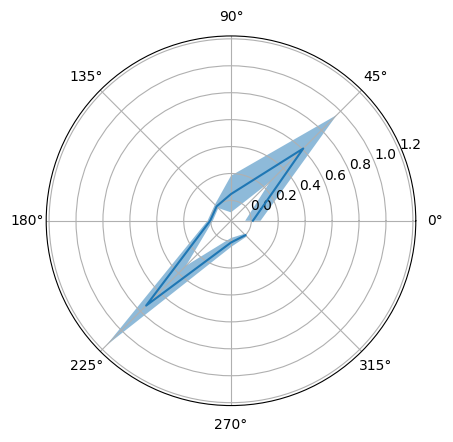

In [13]:
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[10, :],
)
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[10, :] - std_calcium_orientation[10, :],
    mean_calcium_orientation[10, :] + std_calcium_orientation[10, :],
    alpha=0.5,
)

# Is the temporal resolution interfereing with the orientation selectivity?

In [14]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

mean_calcium_orientation = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
std_calcium_orientation = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
for i, orientation in enumerate(orientations):
    for j, freq in enumerate(temporal_frequencies):
        start_times = (
            data["stim_table"]["start"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        end_times = (
            data["stim_table"]["end"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        for roi in range(data["dff"].shape[0]):
            mean_calcium_orientation[roi, i, j] = np.mean(
                [
                    np.mean(data["dff"][roi, s:e])
                    for s, e in zip(start_times, end_times)
                ],
                axis=0,
            )
            std_calcium_orientation[roi, i, j] = np.std(
                [
                    np.mean(data["dff"][roi, s:e])
                    for s, e in zip(start_times, end_times)
                ],
                axis=0,
            )
print(mean_calcium_orientation.shape)

(106, 8, 5)


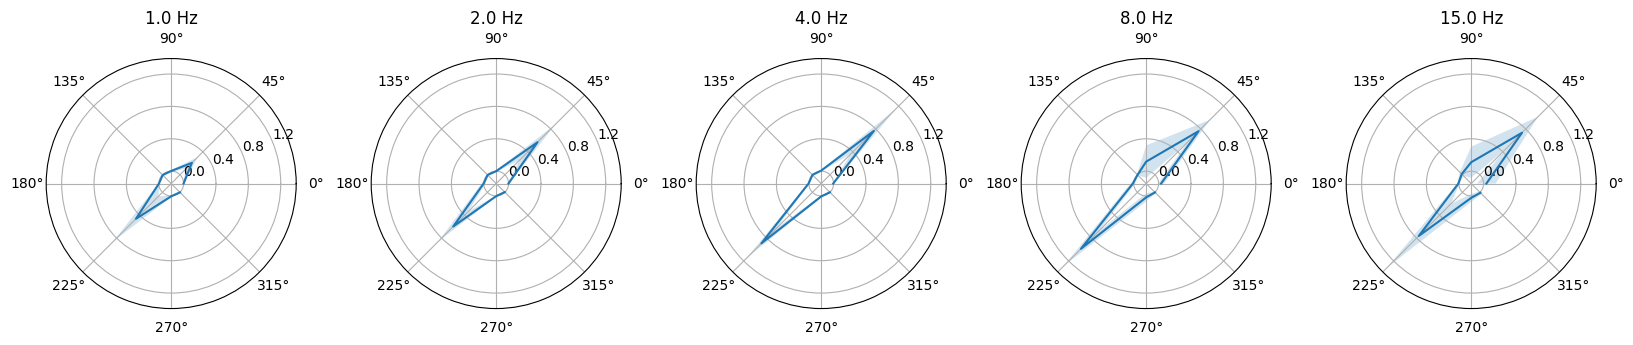

In [15]:
# plot a polar plot for for each orientation and temporal frequency
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_calcium_orientation[10, :, i],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_calcium_orientation[10, :, i] - std_calcium_orientation[10, :, i],
        mean_calcium_orientation[10, :, i] + std_calcium_orientation[10, :, i],
        alpha=0.2,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")
    ax.set_yticks(np.arange(0, 1.5, 0.4))

# Transforming the calcium traces to spikes
* only transform the traces where the drifting gratings were shown
* use the algorithm from coding lab 3 the OASIS algorithm, or trying out py-oopsi

In [16]:
stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)

In [17]:
# thershold the spike data and get the time points where the spike occurs
print(time_data.shape)
print(time_data[spike_data[0, :] == 1])
spike_data[spike_data < 0.2] = 0
spike_data[spike_data >= 0.2] = 1
spike_data = spike_data.astype(int)
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(time_data[spike_data[roi, :] == 1])
spike_times = np.array(spike_times, dtype=object)
spike_times[0]
# plot the spike times, the calcium trace and the deconvolved calcium trace

# Sanity check ###
fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharex=True)
axs.plot(data["t"], data["dff"][10, :])
axs.plot(time_data, spike_data[10, :])
axs.scatter(spike_times[10], np.ones(len(spike_times[10])) * 0.5, c="r", marker="|")
spike_times[0]

NameError: name 'time_data' is not defined

In [ ]:
# mean calcium value for each orientation
# get the spike times for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    for roi in range(data["dff"].shape[0]):
        mean_spike_orientation[roi, i] = np.nansum(
            [np.nansum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )

NameError: name 'spike_data' is not defined

In [ ]:
# %matplotlib qt6
plt.plot(spike_data[10, :])
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[10, :],
)

# Tuning curves of specific cells
Plotting the PSTH by plotting the activity in Hz over the time before, duringand after the stimulus.

In [18]:
print(data["dff"].shape[0])
print(len(data["dff"][0]))

106
115471


In [19]:
import oopsi as ops
import os

# check if spike data is already saved
if os.path.exists("../data/spike_data.npy"):
    spike_data = np.load("../data/spike_data.npy")
else:
    spike_data = np.zeros((data["dff"].shape[0], data["dff"].shape[1]))
    for roi in range(data["dff"].shape[0]):
        # initialize the paraparameters for the oopsi algorithm
        F, P = ops.oopsi_init_par(data["dff"][roi], 1 / 30)
        n, C, post = ops.oopsi_est_map(F, P)
        spike_data[roi] = n
    np.save("../data/spike_data.npy", spike_data)

In [20]:
# threshold the spike data and get the time points where the spike occurs
spike_data[spike_data < 0.2] = 0
spike_data[spike_data >= 0.2] = 1
spike_data = spike_data.astype(int)
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(data["t"][spike_data[roi, :] == 1])
spike_times = np.array(spike_times, dtype=object)
spike_times[0]

print(np.sum(spike_data[10]))

312


In [67]:
print(data["t"]["start"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [140]:
# 2s stimulus hat 60 zeiteinträge, also wenn ich halbe s vor und nach stim will brauch ich jeweils 15 einträge
prestim = 15  # index
poststim = 15
time_window = prestim + poststim + 59
SpikeTable_cell10 = np.zeros((len(data["stim_table"]["start"]), time_window))
for i in range(len(data["stim_table"]["start"])):
    starts = data["stim_table"]["start"][i]
    ends = data["stim_table"]["end"][i]
    if len(spike_data[10][int(starts) - prestim : int(ends) + poststim]) >= 90:
        difference = (
            len(spike_data[10][int(starts) - prestim : int(ends) + poststim])
            - time_window,
        )[0]
        SpikeTable_cell10[i, :] = spike_data[10][
            int(starts) - prestim : int(ends) + poststim - difference
        ]
    else:
        SpikeTable_cell10[i, :] = spike_data[10][
            int(starts) - prestim : int(ends) + poststim
        ]
SpikeTable_cell10 = np.array(SpikeTable_cell10, dtype=object)
print(SpikeTable_cell10.shape)

# calculate instant firing rate for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])

sorted_instant_firing_rate_cell10 = np.zeros((len(orientations), time_window))
for i, orientation in enumerate(orientations):
    sorted_instant_firing_rate_cell10[i, :] = np.nanmean(
        SpikeTable_cell10[data["stim_table"]["orientation"] == orientation, :], axis=0
    )


print(len(sorted_instant_firing_rate_cell10[0]))

(628, 89)
89


In [205]:
# smooth function for the spike data
# use instant rate of specific cells for each orientation
def smooth_rate(instant_firing_rate, window):
    instant_firing_rate = sorted_instant_firing_rate_cell10[1]  # convert to Hz
    # smoothed_rate = np.zeros((len(instant_firing_rate), 1))
    smoothed_rate = np.empty((len(instant_firing_rate), 1))
    smoothed_rate.fill(np.nan)
    # print(smoothed_rate)
    step_size = int(np.floor(window / 2))
    length = np.arange((window - step_size), (len(instant_firing_rate) - step_size))
    for i in range(len(length)):
        print(instant_firing_rate[(i - step_size) : (i + step_size)])
        # print(i)
        smoothed_rate[i, :] = np.nanmean(
            instant_firing_rate[(i - step_size) : (i + step_size)], axis=1
        )

In [204]:
# smooth sorted_instant_firing_rate_cell10
smoothed_firing_rate = smooth_rate(sorted_instant_firing_rate_cell10[0], 5)
print(smoothed_firing_rate)

[]
[]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0.   0.   0.   0.04]
[0.   0.   0.04 0.16]
[0.         0.04       0.16       0.21333333]
[0.04       0.16       0.21333333 0.04      ]
[0.16       0.21333333 0.04       0.08      ]
[0.21333333 0.04       0.08       0.05333333]
[0.04       0.08       0.05333333 0.08      ]
[0.08       0.05333333 0.08       0.05333333]
[0.05333333 0.08       0.05333333 0.02666667]
[0.08       0.05333333 0.02666667 0.05333333]
[0.05333333 0.02666667 0.05333333 0.06666667]
[0.02666667 0.05333333 0.06666667 0.        ]
[0.05333333 0.06666667 0.         0.05333333]
[0.06666667 0.         0.05333333 0.02666667]
[0.         0.05333333 0.02666667 0.04      ]
[0.05333333 0.02666667 0.04       0.04      ]
[0.02666667 0.04       0.04       0.04      ]
[0.04       0.04       0.04       0.02666667]
[0.04       0.04  

C:\Users\Kathrin Root\AppData\Local\Temp\ipykernel_7820\2914417672.py:14: RuntimeWarning: Mean of empty slice
  smoothed_rate[i, :] = np.nanmean(


[0.00014981 0.01857678 0.0011985  0.         0.         0.02666667
 0.         0.        ]


[Text(0, 0, '0.0'),
 Text(1, 0, '45.0'),
 Text(2, 0, '90.0'),
 Text(3, 0, '135.0'),
 Text(4, 0, '180.0'),
 Text(5, 0, '225.0'),
 Text(6, 0, '270.0'),
 Text(7, 0, '315.0')]

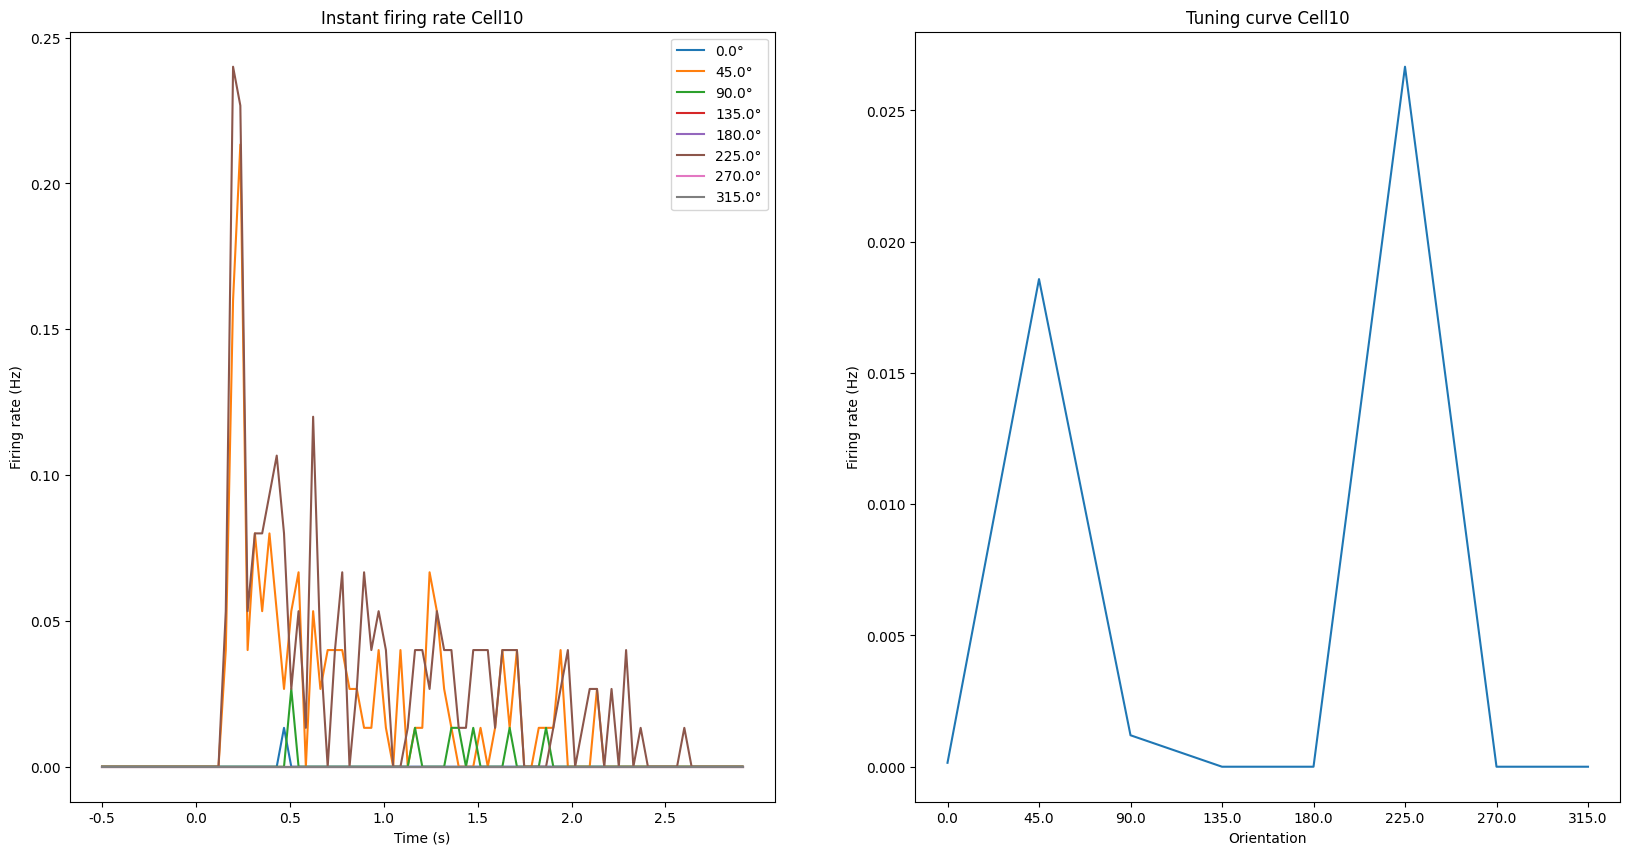

In [72]:
# plot spike density function for each orientation
tuning_curves = np.zeros(8)
for t in range(len(orientations)):
    tuning_curves[t] = np.mean(sorted_instant_firing_rate_cell10[t], axis=0)
print(tuning_curves)

# plot instant rates and tuning curve in one plot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(len(orientations)):
    axs[0].plot(
        np.arange(len(sorted_instant_firing_rate_cell10[0])) / 30,
        sorted_instant_firing_rate_cell10[i],
        label=f"{orientations[i]}°",
    )
axs[0].set_title("Instant firing rate Cell10")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Firing rate (Hz)")
axs[0].set_xticks(np.arange(0, 90, 12.9) / 30)
axs[0].set_xticklabels(np.arange(-0.5, 3, 0.5))
axs[0].legend()
axs[1].plot(np.arange(len(tuning_curves)), tuning_curves)
axs[1].set_title("Tuning curve Cell10")
axs[1].set_xlabel("Orientation")
axs[1].set_ylabel("Firing rate (Hz)")
axs[1].set_xticks(np.arange(0, 8, 1))
axs[1].set_xticklabels(orientations)

In [25]:
# write tuning curve function

In [26]:
# plot tuning curve for each orientation

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing # check
2. Spike inference # needs controlling
3. Tuning function calcium traces fitting # check
4. Tuning function spike fitting
5. Statistical testing. --> quantifying the difference to baseline  
6. Do neighbouring cells share the same orientation?

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.